<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture08_GAN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/generative/dcgan

다음 예제는 텐서플로우 공식 홈페이지 예제를 바탕으로 수정한 가천대학교 DCGAN 실습 입니다.

# DCGAN

이 튜토리얼은 [심층 합성곱 생성적 적대 신경망](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional Generative Adversarial Networks, DCGAN)을 이용하여, 손으로 쓴 숫자들을 어떻게 생성할 수 있는지 보여줍니다. 아래의 애니메이션은 50 epoch동안 훈련한 *Discriminator*가 생성해낸 연속된 이미지들을 보여줍니다. 이미지들은 랜덤한 noise으로 부터 시작되었고, 점차 시간이 지남에 따라 손으로 쓴 숫자들을 닮아가게 됩니다.

![출력 예시](https://tensorflow.org/images/gan/dcgan.gif)

이 코드는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras)와 `tf.GradientTape` 훈련 루프를 사용하여 작성되었습니다.


먼저 tensorflow 환경을 셋팅합니다
### 텐서플로와 다른 라이브러리 불러오기

In [1]:
# !pip install tensorflow-gpu==2.0.0-rc1

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.4.1'

In [ ]:
# GIF를 만들기위해 설치합니다.
# !pip install imageio

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 데이터셋 로딩 및 준비
Generator(G, 생성자)와 Discriminator(D, 감별자)를 훈련하기위해 MNIST 데이터셋을 사용합니다. Generator는 MNIST 데이터셋과 유사하게 손글씨 숫자를 생성 합니다.

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# https://keras.io/api/datasets/ 에서 필요한 데이터셋 load 할 수 있음
# cifar10
# (train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
#fation_MNIST
# (train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator(G)
Generator는 시드값 (seed; random noise)으로부터 이미지를 생성하기 위해, [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/guide/keras?hl=ko#sequential_model) (업샘플링) 층을 이용합니다. 처음 `Dense`층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU?hl=ko)을 사용합니다.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(훈련이 되지않은) G를 이용해 이미지를 생성해봅니다.

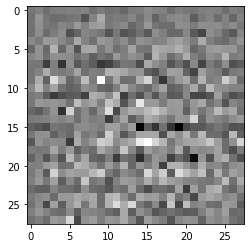

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator(D)
Discriminator는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기(classifier)입니다.

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

(훈련이 되지 않은) D를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00128722]], shape=(1, 1), dtype=float32)


## Loss 함수와 Optimizer 정의
두 모델의 loss 함수와 optimizer를 정의합니다.

In [13]:
# 이 함수는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss 함수
이 함수는 D가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 D의 예측과 1로 이루어진 행렬을 비교하고, 생성된 이미지(fake)에 대한 D의 예측과 0으로 이루어진 행렬을 비교합니다.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss 함수
G의 loss 함수는 D를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 G가 원활히 수행되고 있다면, D는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 생성된 이미지에 대한 D의 결정을 1로 이루어진 행렬과 비교합니다.

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

D와 G는 따로 훈련되기 때문에, D와 G의 optimizer는 따로 생성합니다.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoint 저장
오랫동안 training이 진행되면서 네트워크 등의 문제로 training 이 중단되는 경우가 있기 때문에, training 중 모델을 저장하면 그 시점에서 부터 재 training이 가능합니다.  

또, 저장한 checkpoint를 이용해 모델(또는 모델 weight)을 불러와서 test, validation에 사용할 수 있습니다.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 훈련 루프 정의하기

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 시드를 셋팅
# 여기서는 GIF 애니메이션에서 epoch에 따라 변화 내용을 시각화하기 위해 사용 
# 또, hyperparameter 튜닝할 때, z값이 동일해야 결과를 비교 가능하기 때문에 고정하기도 함
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training loop는 G가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. D를 사용하여 진짜 이미지와 D가 생성해낸 가짜 이미지를 분류합니다. 각 모델의 loss를 계산하고, gradients를 사용해 G와 D를 업데이트합니다.

In [19]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # TODO
      # Generator에서 fake 이미지 생성

      # Discriminator에 real 이미지 넣어줌

      # Discriminator에 fake 이미지 넣어줌
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
generated_images = generator(noise, training=True)

real_output = discriminator(images, training=True)
fake_output = discriminator(generated_images, training=True)

NameError: ignored

**이미지 생성 및 저장**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 모델 훈련
위에 정의된 `train()` 함수를 G와 D를 동시에 훈련하기 위해 호출합니다. GAN을 학습할 때는 G와 D가 서로를 overpower하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.)
훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 점차 진짜 숫자처럼 보일 것입니다. 50 epoch가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, epoch마다 1분정도 소요될 것입니다.

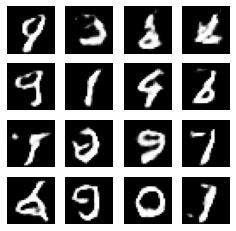

CPU times: user 2min 15s, sys: 23.1 s, total: 2min 38s
Wall time: 9min 13s


In [ ]:
%%time
train(train_dataset, EPOCHS)

마지막 체크포인트를 복구합니다.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성

In [ ]:
# 특정 epoch에서 생성된 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

`imageio`로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다: 

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)